In [1]:
import mne
from mne.datasets import visual_92_categories
data_path = visual_92_categories.data_path()


Using default location ~/mne_data for visual_92_categories...



Verifying hash 74f50bbeb65740903eadc229c9fa759f.



Verifying hash 203410a98afc9df9ae8ba9f933370e20.
Decompressing the archive: /home/victormp/mne_data/MNE-visual_92_categories-data-part1.tar.gz
(please be patient, this can take some time)
Decompressing the archive: /home/victormp/mne_data/MNE-visual_92_categories-data-part2.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['/home/victormp/mne_data/MNE-visual_92_categories-data', '/home/victormp/mne_data/MNE-visual_92_categories-data']


In [ ]:
## https://mne.tools/dev/auto_examples/decoding/decoding_rsa.html#sphx-glr-auto-examples-decoding-decoding-rsa-py

In [2]:
import os.path as op
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import MDS

import mne
from mne.io import read_raw_fif, concatenate_raws

In [6]:
## Define stimulus - trigger mapping
fname = op.join(data_path, 'visual_stimuli.csv')
conds = read_csv(fname)
print(conds.head(5))
print(conds.tail(5))

   trigger       condition  human  face  animal  natural
0        0  human bodypart      1     0       1        1
1        1  human bodypart      1     0       1        1
2        2  human bodypart      1     0       1        1
3        3  human bodypart      1     0       1        1
4        4  human bodypart      1     0       1        1
    trigger             condition  human  face  animal  natural
87       87  artificial inanimate      0     0       0        0
88       88  artificial inanimate      0     0       0        0
89       89  artificial inanimate      0     0       0        0
90       90  artificial inanimate      0     0       0        0
91       91  artificial inanimate      0     0       0        0


In [7]:
## restrict number of conditions: 
max_trigger = 24
conds = conds[:max_trigger]  # take only the first 24 rows

In [11]:
print(conds) # 12 human bodypart, 12 human face. 

    trigger       condition  human  face  animal  natural
0         0  human bodypart      1     0       1        1
1         1  human bodypart      1     0       1        1
2         2  human bodypart      1     0       1        1
3         3  human bodypart      1     0       1        1
4         4  human bodypart      1     0       1        1
5         5  human bodypart      1     0       1        1
6         6  human bodypart      1     0       1        1
7         7  human bodypart      1     0       1        1
8         8  human bodypart      1     0       1        1
9         9  human bodypart      1     0       1        1
10       10  human bodypart      1     0       1        1
11       11  human bodypart      1     0       1        1
12       12      human face      1     1       1        1
13       13      human face      1     1       1        1
14       14      human face      1     1       1        1
15       15      human face      1     1       1        1
16       16   

array([[0, 'human bodypart', 1, 0, 1, 1],
       [1, 'human bodypart', 1, 0, 1, 1],
       [2, 'human bodypart', 1, 0, 1, 1],
       [3, 'human bodypart', 1, 0, 1, 1],
       [4, 'human bodypart', 1, 0, 1, 1],
       [5, 'human bodypart', 1, 0, 1, 1],
       [6, 'human bodypart', 1, 0, 1, 1],
       [7, 'human bodypart', 1, 0, 1, 1],
       [8, 'human bodypart', 1, 0, 1, 1],
       [9, 'human bodypart', 1, 0, 1, 1],
       [10, 'human bodypart', 1, 0, 1, 1],
       [11, 'human bodypart', 1, 0, 1, 1],
       [12, 'human face', 1, 1, 1, 1],
       [13, 'human face', 1, 1, 1, 1],
       [14, 'human face', 1, 1, 1, 1],
       [15, 'human face', 1, 1, 1, 1],
       [16, 'human face', 1, 1, 1, 1],
       [17, 'human face', 1, 1, 1, 1],
       [18, 'human face', 1, 1, 1, 1],
       [19, 'human face', 1, 1, 1, 1],
       [20, 'human face', 1, 1, 1, 1],
       [21, 'human face', 1, 1, 1, 1],
       [22, 'human face', 1, 1, 1, 1],
       [23, 'human face', 1, 1, 1, 1]], dtype=object)

In [18]:
## stimulus trigger mapping: 
conditions = []
for c in conds.values:
    cond_tags = list(c[:2]) ## 0-23 and either 
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)] ## adds "not" when there is 0 in dummy.
    conditions.append('/'.join(map(str, cond_tags)))
print(conditions[:10])

['0/human bodypart/human/not-face/animal/natural', '1/human bodypart/human/not-face/animal/natural', '2/human bodypart/human/not-face/animal/natural', '3/human bodypart/human/not-face/animal/natural', '4/human bodypart/human/not-face/animal/natural', '5/human bodypart/human/not-face/animal/natural', '6/human bodypart/human/not-face/animal/natural', '7/human bodypart/human/not-face/animal/natural', '8/human bodypart/human/not-face/animal/natural', '9/human bodypart/human/not-face/animal/natural']
['10/human bodypart/human/not-face/animal/natural', '11/human bodypart/human/not-face/animal/natural', '12/human face/human/face/animal/natural', '13/human face/human/face/animal/natural', '14/human face/human/face/animal/natural', '15/human face/human/face/animal/natural', '16/human face/human/face/animal/natural', '17/human face/human/face/animal/natural', '18/human face/human/face/animal/natural', '19/human face/human/face/animal/natural', '20/human face/human/face/animal/natural', '21/human

In the above cell we are looping over each row (image/trial) in our conditions array. 
The first two columns are the ID of the image and the condition while the last four columns are dummy-columns indicating whether some feature is present (e.g. face = 1 or not-face = 0). 
We turn this array into a list with the values of the six different columns (now in text instead of in 0/1 encoding) for each image. 

In [19]:
## turn them into a dictionary: 
event_id = dict(zip(conditions, conds.trigger + 1))
event_id['0/human bodypart/human/not-face/animal/natural']

1

In [21]:
## read MEG data 
n_runs = 4 # 4 for full data (use less to speed up computations)
fname = op.join(data_path, 'sample_subject_%i_tsss_mc.fif')
raws = [read_raw_fif(fname % block, verbose='error')
        for block in range(n_runs)]  # ignore filename warnings
raw = concatenate_raws(raws)

events = mne.find_events(raw, min_duration=.002)

events = events[events[:, 2] <= max_trigger]

4142 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]


In [22]:
## epoch data
picks = mne.pick_types(raw.info, 
                       meg=True)
epochs = mne.Epochs(raw, 
                    events=events, 
                    event_id=event_id, ## here we have specified our IDs. 
                    baseline=None,
                    picks=picks, 
                    tmin=-.1, 
                    tmax=.500, 
                    preload=True)


Not setting metadata
Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated
Loading data for 720 events and 601 original time points ...
0 bad epochs dropped


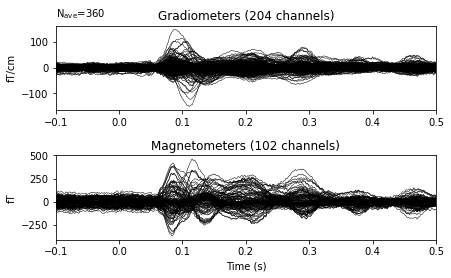

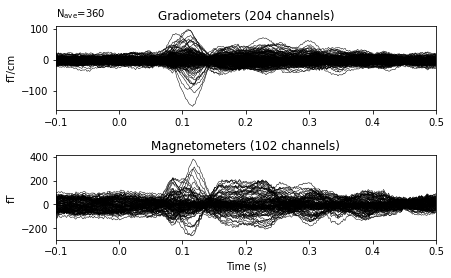

In [26]:
epochs['face'].average().plot();
epochs['not-face'].average().plot();

"Representational Similarity Analysis (RSA) is a neuroimaging-specific appelation to refer to statistics applied to the confusion matrix also referred to as the representational dissimilarity matrices (RDM).

Compared to the approach from Cichy et al. we’ll use a multiclass classifier (Multinomial Logistic Regression) while the paper uses all pairwise binary classification task to make the RDM. Also we use here the ROC-AUC as performance metric while the paper uses accuracy. Finally here for the sake of time we use RSA on a window of data while Cichy et al. did it for all time instants separately."

In [27]:
# Classify using the average signal in the window 50ms to 300ms
# to focus the classifier on the time interval with best SNR.
clf = make_pipeline(StandardScaler(),
                    LogisticRegression(C=1, solver='liblinear',
                                       multi_class='auto'))
X = epochs.copy().crop(0.05, 0.3).get_data().mean(axis=2)
y = epochs.events[:, 2]

classes = set(y)
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

# Compute confusion matrix for each cross-validation fold
y_pred = np.zeros((len(y), len(classes)))
for train, test in cv.split(X, y):
    # Fit
    clf.fit(X[train], y[train])
    # Probabilistic prediction (necessary for ROC-AUC scoring metric)
    y_pred[test] = clf.predict_proba(X[test])

In [28]:
#Compute confusion matrix using ROC-AUC
confusion = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        confusion[ii, jj] = roc_auc_score(y == train_class, y_pred[:, jj])
        confusion[jj, ii] = confusion[ii, jj]

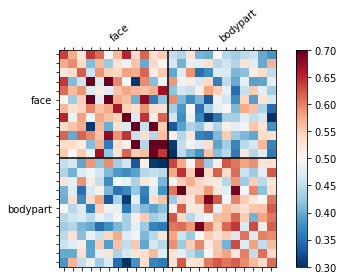

In [29]:
labels = [''] * 5 + ['face'] + [''] * 11 + ['bodypart'] + [''] * 6
fig, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap='RdBu_r', clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=40, ha='left')
ax.axhline(11.5, color='k')
ax.axvline(11.5, color='k')
plt.colorbar(im)
plt.tight_layout()
plt.show()

Confusion matrix related to mental representations have been historically summarized with dimensionality reduction using multi-dimensional scaling [1]. See how the face samples cluster together.

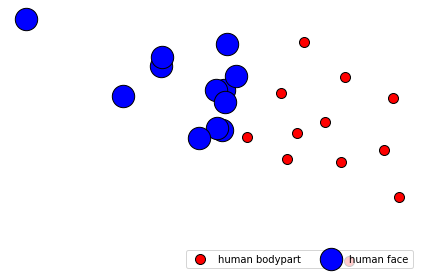

In [30]:
fig, ax = plt.subplots(1)
mds = MDS(2, random_state=0, dissimilarity='precomputed')
chance = 0.5
summary = mds.fit_transform(chance - confusion)
cmap = plt.get_cmap('rainbow')
colors = ['r', 'b']
names = list(conds['condition'].values)
for color, name in zip(colors, set(names)):
    sel = np.where([this_name == name for this_name in names])[0]
    size = 500 if name == 'human face' else 100
    ax.scatter(summary[sel, 0], summary[sel, 1], s=size,
               facecolors=color, label=name, edgecolors='k')
ax.axis('off')
ax.legend(loc='lower right', scatterpoints=1, ncol=2)
plt.tight_layout()
plt.show()